In [60]:
import os
import shutil
import pandas as pd
import holidays
from time import time
from datetime import date, datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from varname.helpers import Wrapper

In [61]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Aggregated demand data

In [62]:
def to_datetime(df, col_name):
    try:
        df.index = df[col_name].apply(lambda x: pd.to_datetime(str(x), format='%d.%m.%Y', utc=True))
        df.index = df.index.tz_convert('Europe/Berlin').tz_localize(None) 
    except:
        df.index = pd.to_datetime(df.index, utc = True).tz_convert('Europe/Berlin').tz_localize(None) 
    df.index = df.index.date
    df.index = pd.to_datetime(df.index) 
    return df.index

## BDEW (calculated from ENTSO-G, corrected with destatis)

In [63]:
bdew = pd.read_csv(os.path.join(data_path, "bdew.csv"), index_col =0)
bdew.index = to_datetime(bdew, " ")
bdew = (bdew / (10**9)).rename(columns={"Verbrauch":"bdew [TWh]"})

## Trading Hub Europe: SLPs & RLMs

THE original data

In [64]:
#read
the = pd.read_csv(os.path.join(data_path, "THE.csv"), sep=";")
the.index = to_datetime(the, "Gastag")


the_new = pd.read_csv(os.path.join(data_path, "THE_new.csv"), sep=";")
the_new.index = the_new["Gasday"]
the_new.index = to_datetime(the_new, the_new.index)

the = pd.concat([the,the_new], axis=0)

#to numeric
the = the[the.columns[~the.columns.isin(["Gastag", "Status", "Gasday", "State"])]].fillna("0")
the = the.iloc[::-1] 
the = the.apply(lambda x: x.apply(lambda y: float(y.replace(".", "").replace(",", ""))))

#from kWh to TWh
the = the / (10**9)

Gas pool data from: https://www.tradinghub.eu/de-de/Download/Archiv-GASPOOL / "Sonstiges" / "Aggregierte Verbrauchsdaten"

In [65]:
gaspool = pd.read_csv(os.path.join(data_path, "gaspool.csv"), sep=";")
gaspool.index = to_datetime(gaspool, "Datum")
gaspool.drop("Datum", 1, inplace=True)

#from MWh to TWh
gaspool = gaspool / (10**6)

NCG data from:https://www.tradinghub.eu/de-de/Download/Archiv-NetConnect-Germany / "Sonstiges" / "Aggregierte Verbrauchsdaten"

In [66]:
#in KWh
ncg = pd.read_csv(os.path.join(data_path, "ncg.csv"), sep=";")
ncg.index = to_datetime(ncg, "DayOfUse")

ncg.drop(["DayOfUse", "Status"], 1, inplace=True)
ncg.drop(list(ncg.filter(like='Unit', axis=1).columns), 1, inplace=True)

#from kWh to TWh
ncg = ncg / (10**9)

In [67]:
def get_df_name(df):
    return [x for x in globals() if globals()[x] is df][0]

def return_summed_df(df, domain, name):
    return df[df.filter(like=domain, axis=1).columns].sum(1).to_frame().rename(
    columns={0:"{}_{} [TWh]".format(domain, name)})

def sum_consumptions(df):    
    name = get_df_name(df)
    return return_summed_df(df, "SLP", name), return_summed_df(df, "RLM", name) 

def sum_single_col_dfs(df_1, df_2, slp_sum=True, **alternative_name):
    if slp_sum==False:
        name = alternative_name.values()
        return (df_1.iloc[:,0] + df_2.iloc[:,0]).to_frame().rename(columns={
            0:name}) 
    else: 
        name = get_df_name(df_1).split("_")[0]
        return (df_1.iloc[:,0] + df_2.iloc[:,0]).to_frame().rename(columns={
            0:"{}_sum [TWh]".format(name)})

In [68]:
the_slp, the_rlm = sum_consumptions(the)
gaspool_slp, gaspool_rlm = sum_consumptions(gaspool)
ncg_slp, ncg_rlm = sum_consumptions(ncg)

the_sum = sum_single_col_dfs(the_slp, the_rlm)
gaspool_sum = sum_single_col_dfs(gaspool_slp, gaspool_rlm)
ncg_sum = sum_single_col_dfs(ncg_slp, ncg_rlm)

before_the_slp = sum_single_col_dfs(gaspool_slp, ncg_slp).loc[gaspool_slp.index]
before_the_rlm = sum_single_col_dfs(gaspool_rlm, ncg_rlm).loc[gaspool_slp.index]
before_the_sum = sum_single_col_dfs(ncg_sum, gaspool_sum, slp_sum=False, 
                                    alternative_name="aggregated_gaspool_ngc").loc[gaspool_slp.index]

the_whole_slp = pd.concat([the_slp, before_the_slp], axis = 0).sum(1).sort_index(
    ).to_frame().rename(columns={0:"the_combined_slp"})
the_whole_rlm = pd.concat([the_rlm.iloc[:,0], before_the_rlm], axis = 0).sum(1).sort_index(
    ).to_frame().rename(columns={0:"the_combined_rlm"})
the_whole_sum = pd.concat([the_sum, before_the_sum], axis = 0).sum(1).sort_index(
    ).to_frame().rename(columns={0:"the_combined_sum"})

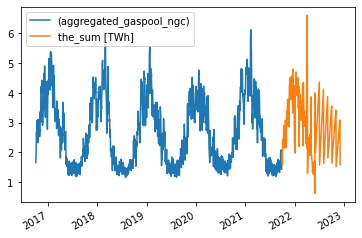

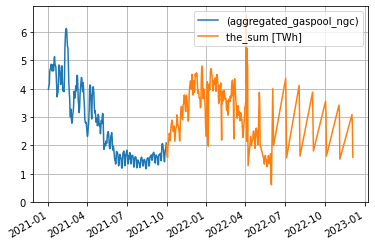

In [69]:
series_all = pd.concat([before_the_sum, the_sum], axis=0)
series_all.plot()
series_all["2021-01-01":].plot(ylim=0)
plt.grid()

In [70]:
the_whole_slp[the_whole_slp.index.year==2020].sum()

the_combined_slp    379.140945
dtype: float64

## THE-BDEW comparison

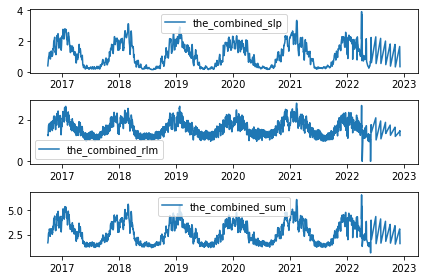

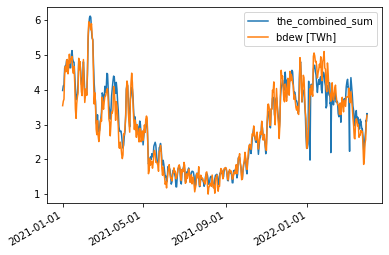

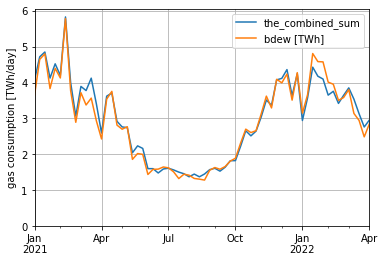

In [71]:
fig, axs = plt.subplots(3)

df_list = [the_whole_slp, the_whole_rlm, the_whole_sum]

for i, df in enumerate(df_list):
    axs[i].plot(df.index, df.iloc[:,0], label=df.columns[0])
    axs[i].legend()
    plt.tight_layout()

ax = the_whole_sum.loc[bdew.index].plot()
bdew.plot(ax=ax)
ax.set_xticks(ax.get_xticks()[::2])

pd.concat([the_whole_sum, bdew], axis=1).dropna().resample('1w').mean().plot(ylim=0).set_ylabel("gas consumption [TWh/day]")
plt.grid()

plt.show()

##Über & danach Unterschätzung 

In [72]:
common_date = bdew.iloc[0].name
bdew_sum = bdew.loc[bdew.index>common_date].sum()[0]
the_sum_sum = the_whole_sum.loc[the_whole_sum.index>common_date].sum()[0]

print("Energy consumption since: {}".format(common_date.strftime("%Y-%m-%d")) + "\n" +
      "the [TWh]: "+ str(the_sum_sum) + "\n" +
      "bdew [TWh]: "+ str(bdew_sum) + "\n" +
      "delta [%]: " + str(100 * (the_sum_sum - bdew_sum )/ 
                    the_sum_sum)
                        ) 

Energy consumption since: 2021-01-01
the [TWh]: 1620.9803168059998
bdew [TWh]: 1336.471390021
delta [%]: 17.551658328930227


# Proxies / control variables / disaggregated demand
## Estimated SLP

In [73]:
estimated = pd.read_csv(os.path.join(data_path, "SLPs_new.csv"), index_col="time")
estimated.index = to_datetime(estimated, " ")

In [146]:
estimated_new =  pd.read_csv(os.path.join(data_path, "when2heat_filtered.csv"), index_col="utc_timestamp")
estimated_new.index = to_datetime(estimated_new, " ")
#estimated_new = estimated_new.loc[:,:"DE_heat_profile_space_COM"]

#estimated_new = (estimated_new.iloc[:,1:-1].astype(float) * 0.27777777777778).resample("d").sum()

estimated_new = (estimated_new.iloc[:,1:-1].astype(float) * 9.396810210061496e-05).resample("d").sum()

In [147]:
estimated_new["DE_heat_profile_space_COM"][estimated_new.index.year==2020] #* 9.396810210061496e-05

2020-01-01    0.718950
2020-01-02    0.729568
2020-01-03    0.597073
2020-01-04    0.508837
2020-01-05    0.515509
                ...   
2020-12-27    0.600644
2020-12-28    0.640956
2020-12-29    0.635224
2020-12-30    0.620096
2020-12-31    0.639547
Freq: D, Name: DE_heat_profile_space_COM, Length: 366, dtype: float64

In [144]:
estimated_new[estimated_new.index.year==2015].tail()

,DE_heat_demand_space,DE_heat_demand_space_COM,DE_heat_demand_space_MFH,DE_heat_demand_space_SFH,DE_heat_demand_total,DE_heat_demand_water,DE_heat_demand_water_COM,DE_heat_demand_water_MFH,DE_heat_demand_water_SFH,DE_heat_profile_space_COM,DE_heat_profile_space_MFH,DE_heat_profile_space_SFH,DE_heat_profile_water_COM,DE_heat_profile_water_MFH
2015-12-27,360528.888889,121203.333333,71790.277778,167535.555556,427730.555556,67201.111111,19822.222222,14214.166667,33165.277778,716.944444,762.222222,762.777778,716.111111,761.111111
2015-12-28,369588.333333,131857.500000,71359.166667,166372.500000,438689.444444,69101.388889,21721.388889,14214.166667,33165.277778,780.555556,757.500000,758.055556,784.722222,761.111111
2015-12-29,365820.833333,130445.277778,70718.333333,164656.666667,434928.611111,69108.333333,21728.333333,14214.166667,33165.277778,772.222222,750.833333,748.333333,785.277778,761.111111
2015-12-30,368769.722222,130729.166667,71441.944444,166598.611111,437672.500000,68903.611111,21523.611111,14214.166667,33165.277778,773.333333,758.333333,758.611111,777.222222,761.111111
2015-12-31,374580.277778,133744.166667,72197.222222,168637.222222,443688.333333,69108.333333,21728.333333,14214.166667,33165.277778,791.944444,766.111111,766.944444,785.277778,761.111111


In [121]:
estimated[estimated.index.year==2020].tail()

,commercial_space TWh,residential_space TWh,commercial_water TWh,residential_water TWh,aggregated(no_dist_heat),dist_heat,aggregated(incl_dist_heat)
2020-12-27,0.650233,1.280117,0.020531,0.151376,2.102258,0.108084,2.210342
2020-12-28,0.694194,1.248148,0.022530,0.151376,2.116248,0.108803,2.225052
2020-12-29,0.687624,1.237497,0.022559,0.151376,2.099056,0.107920,2.206975
2020-12-30,0.672110,1.221973,0.022355,0.151376,2.067814,0.106313,2.174127
2020-12-31,0.691976,1.246286,0.022614,0.151376,2.112251,0.108598,2.220849


In [15]:
estimated["commercial"] = estimated[["commercial_space TWh", "commercial_water TWh"]].sum(1)
estimated["residential"] = estimated[["residential_space TWh", "residential_water TWh"]].sum(1)

Gas consumption according to AGEB in decentralized units will be mostly small CHP and hence temperature dependent. THis increases overall temperature-dependent gas consumption from 384 to 396 TWh.

In [16]:
estimated["scaled_space_private"] = estimated['residential'] * 254 / estimated['residential'][
    estimated.index.year==2020].sum()

estimated["scaled_space_tertiary"] = estimated['commercial'] * 98 / estimated['commercial'][
    estimated.index.year==2020].sum()

estimated["scaled_decentral_chp"] = estimated['commercial'] * 15 / estimated['commercial'][
    estimated.index.year==2020].sum()

estimated["scaled_space_industry"] = estimated['commercial'] * 25 / estimated['commercial'][
    estimated.index.year==2020].sum()

estimated["scaled_district_heat"] = estimated['dist_heat'] * 19 / estimated['dist_heat'][
    estimated.index.year==2020].sum()

estimated['aggregated(incl_small_chp)'] = estimated[
    ["scaled_space_private","scaled_space_tertiary","scaled_decentral_chp","scaled_space_industry","scaled_district_heat"]
                                                   ].sum(1)


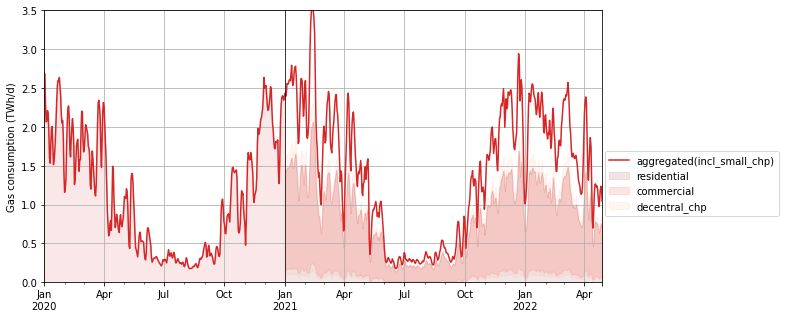

In [17]:
estimated['aggregated(incl_small_chp)'].plot(color='tab:red', figsize=(10,5))
plt.grid()

estimated2020 = estimated[estimated.index.year==2020]['aggregated(incl_small_chp)']
estimated2021 = estimated.loc["2021-01-01":]

plt.fill_between(estimated2020.index, 0, estimated2020, color='tab:red', alpha=0.1)

bottom = 0
for sector, c, label in [("scaled_space_private", "maroon", "residential"), (
    "scaled_space_industry","red", "commercial"), ("scaled_decentral_chp", "lightsalmon", "decentral_chp") ]:
    plt.fill_between(estimated2021.index, bottom, estimated2021[sector], color=c, alpha=0.1, label = label)
    bottom += estimated2021[sector]

plt.xlabel('')
plt.ylabel('Gas consumption (TWh/d)')
plt.legend(loc='upper right', bbox_to_anchor=(1.325, 0.5))
plt.ylim(0, 3.5)
plt.axvline('2021-01-01', color='black', linewidth=0.7)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)

## Gas for electricity generation

In [18]:
electricity_from_gas = pd.read_csv(os.path.join(data_path, "electricity_from_gas.csv"), 
                                   index_col=0, parse_dates=True).iloc[:, 0]

electricity_from_gas = electricity_from_gas /10**6

Scaled to 185 TWh in 2020, which is the sum of public power plants, public CHP, and industrial power plants (probably also mostly CHP):

In [19]:
gas_to_electricity = electricity_from_gas * 189 / (
    electricity_from_gas[electricity_from_gas.index.year==2020].sum())

gas_to_electricity_public_pp = electricity_from_gas * 106 / (
    electricity_from_gas[electricity_from_gas.index.year==2020].sum())

gas_to_electricity_public_chp = electricity_from_gas * 34 / (
    electricity_from_gas[electricity_from_gas.index.year==2020].sum())

gas_to_electricity.name = "gas_to_electricity"

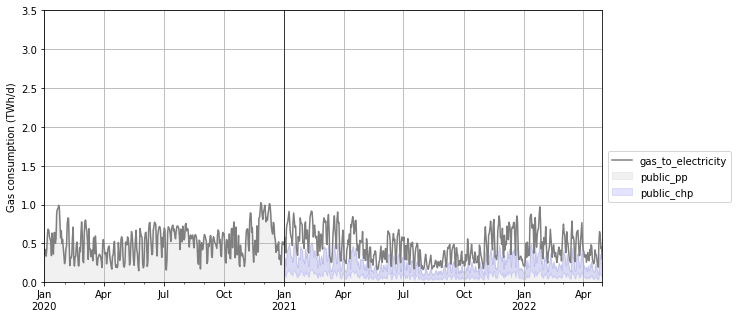

In [20]:
gas_to_electricity.plot(color='tab:grey', figsize=(10,5))
plt.grid()
power2020 = gas_to_electricity[gas_to_electricity.index.year==2020]
index_21_22 = gas_to_electricity[gas_to_electricity.index.year!=2020].index

plt.fill_between(power2020.index, 0, power2020, color='tab:grey', alpha=0.1)
plt.fill_between(index_21_22, 0, gas_to_electricity_public_pp[index_21_22], color='grey', alpha=0.1, label="public_pp")
plt.fill_between(index_21_22, gas_to_electricity_public_pp[index_21_22], gas_to_electricity_public_chp[index_21_22], color='blue', alpha=0.1, label="public_chp")


plt.legend(loc='upper right', bbox_to_anchor=(1.24, 0.5))
plt.xlabel('')
plt.ylabel('Gas consumption (TWh/d)')
plt.ylim(0, 3.5)
plt.axvline('2021-01-01', color='black', linewidth=0.7)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)

## Gas prices

In [58]:
gas_prices = pd.read_csv(os.path.join(data_path, "Dutch TTF Natural Gas Futures Recent.csv"), index_col=0)
gas_prices = gas_prices["Price"].to_frame().rename(columns={
    "Price":"gas_price [€/MWh]"}).dropna()
gas_prices.index = pd.to_datetime(gas_prices.index, utc = True).date

In [59]:
gas_prices

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
"Apr 29, 2022",99.450,99.450,99.450,99.450,-,-0.69%
"Apr 28, 2022",100.142,100.142,100.142,100.142,-,-6.78%
"Apr 27, 2022",107.425,107.425,107.425,107.425,-,4.08%
"Apr 26, 2022",103.210,103.210,103.210,103.210,-,11.18%
"Apr 25, 2022",92.835,92.835,92.835,92.835,-,-2.15%
...,...,...,...,...,...,...
"Jan 08, 2021",20.120,20.400,20.700,19.890,0.39K,4.22%
"Jan 07, 2021",19.305,18.275,19.420,18.275,0.18K,9.91%
"Jan 06, 2021",17.565,17.875,18.520,17.375,0.70K,-2.42%


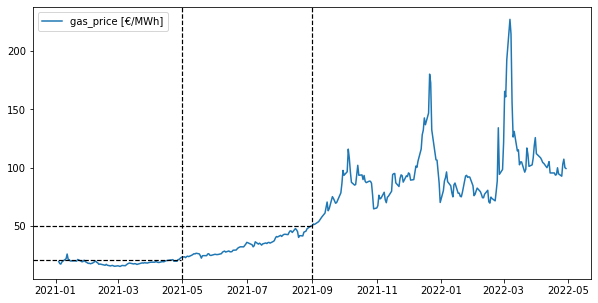

In [22]:
gas_prices.plot(figsize=(10,5))
plt.axvline(x="2021-09-1", color='k', linestyle='--', lw=1.2)
plt.axvline(x="2021-05-1", color='k', linestyle='--', lw=1.2)
plt.axhline(xmax=0.5, y=50, color='k', linestyle='--', lw=1.2)
plt.axhline(xmax=0.265, y=21, color='k', linestyle='--', lw=1.2)

Combine sources

In [29]:
the_whole_slp = the_whole_slp.drop_duplicates()
the_whole_rlm = the_whole_rlm.drop_duplicates()
gas_prices = gas_prices.drop_duplicates()

In [30]:
df_all = the_whole_slp.join(
    [the_whole_rlm, bdew, gas_to_electricity, electricity_from_gas, 
        gas_prices, estimated[
    ["scaled_space_private","scaled_space_tertiary","scaled_decentral_chp","scaled_space_industry","scaled_district_heat", 'aggregated(incl_small_chp)']
                                                   ]
    ]
)

In [31]:
pd.concat([
    the_whole_slp.iloc[:,0], the_whole_rlm.iloc[:,0]
], axis=1)

ValueError: cannot reindex from a duplicate axis

In [ ]:
df_all = pd.concat(
    [
     the_whole_slp, the_whole_rlm, bdew, gas_to_electricity, electricity_from_gas, 
        gas_prices, estimated[
    ["scaled_space_private","scaled_space_tertiary","scaled_decentral_chp","scaled_space_industry","scaled_district_heat", 'aggregated(incl_small_chp)']
                                                   ]
    ], 
    axis = 1)

In [32]:
df_all

,the_combined_slp,the_combined_rlm,bdew [TWh],gas_to_electricity,electricity_from_gas,gas_price [€/MWh],scaled_space_private,scaled_space_tertiary,scaled_decentral_chp,scaled_space_industry,scaled_district_heat,aggregated(incl_small_chp)
2016-10-01,0.396332,1.262703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-02,0.511865,1.229047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-03,0.616591,1.300171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-04,0.709381,1.546009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-05,0.882730,1.629043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-04,1.509345,1.632412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-05,0.324281,1.193549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-03,1.653093,1.436176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-04,1.155417,1.471865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
first = the_whole_slp.iloc[0].name
last = the_whole_slp.iloc[-1].name

def unify_index(df):
    try:
        return df.loc[(df.index >= first) & (df.index <= last)]
    except:
        return df.loc[(df.index.date >= first) & (df.index.date <= last)]

In [34]:
df_all = unify_index(df_all)

In [35]:
df_all

,the_combined_slp,the_combined_rlm,bdew [TWh],gas_to_electricity,electricity_from_gas,gas_price [€/MWh],scaled_space_private,scaled_space_tertiary,scaled_decentral_chp,scaled_space_industry,scaled_district_heat,aggregated(incl_small_chp)
2016-10-01,0.396332,1.262703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-02,0.511865,1.229047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-03,0.616591,1.300171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-04,0.709381,1.546009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-05,0.882730,1.629043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-04,1.509345,1.632412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-05,0.324281,1.193549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-03,1.653093,1.436176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-04,1.155417,1.471865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Analysis & plotting

## Align indexes
All calculations and plots are done for the same period: 01.10.2021-25.03.2022

# Subtract gas for electricity generation

## THE vs. our estimates

In [36]:
y1=df_all["aggregated(incl_small_chp)"]
y2= df_all["the_combined_slp"]
y3 = df_all["the_combined_rlm"]

### Weekly analyis: Russian invasion: 24.02. (Thu), Fasching: 28.02.-02.03. (Mon-Wed)

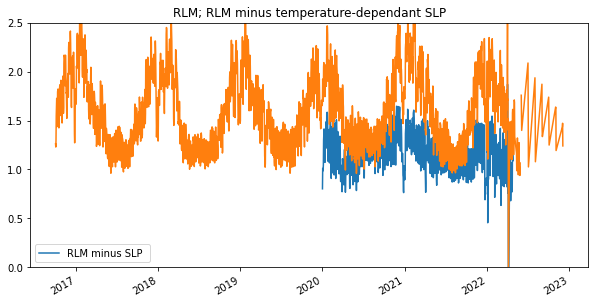

In [37]:
ax = (y3 - 0.34*y1).to_frame().rename(columns={0:"RLM minus SLP "}).plot()
ax.set_ylim(0,2.5)
y3.plot(
    ax=ax, title = "RLM; RLM minus temperature-dependant SLP", figsize=(10,5))
plt.show()

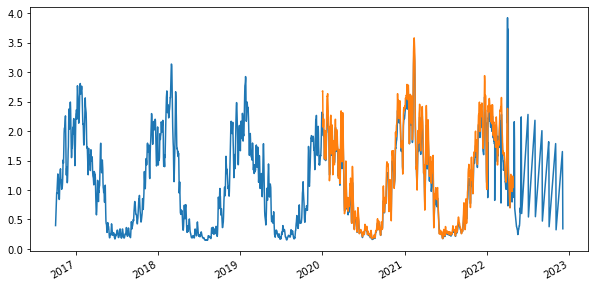

In [38]:
ax = y2.plot()
y1.plot(ax=ax, figsize=(10,5))

plt.show()

# Export

In [39]:
df = df_all

In [40]:
df['index']= df.index
df['time'] = range(len(df))
df['time'] = df['time'].apply(float)
df['year'] = df["index"].apply(lambda x: x.year)
df['month'] = df['index'].apply(lambda x: x.month)

In [41]:
df['weekday'] = df['index'].apply(lambda x: x.strftime('%A'))
df['weekday_num'] = df['index'].apply(lambda x: x.weekday())
df['monday'] = df['weekday'].apply(lambda x: int(x=="Monday"))
df['friday'] = df['weekday'].apply(lambda x: int(x=="Friday"))
df['weekend'] = df['weekday'].apply(lambda x: int(x in ["Saturday", "Sunday"]))

In [42]:
df['christmas_period'] = df['index'].apply(
    lambda x: int((x.month==12)&(x.day in range(24,32)))
)

country_holidays = holidays.CountryHoliday('DE', prov='BY')
df['holiday'] = df['index'].apply(lambda x: int(x in country_holidays))
df['bridgeday'] = ((
    (df['holiday'].shift(24) + df['holiday'].shift(-24)) * 
    (df['weekend'].shift(24) + df['weekend'].shift(-24))
) > 0).apply(int)

In [43]:
df.to_csv(os.path.join(data_path, "preprocessed.csv"))